# IPL Win Probability Predictor
### At a given amount of time, which team has what probabilty of winning the game, ye calculate karna hai!
Suppose, RCB vs MI ka match chal rha h so we will have to keep in mind shit tons of things like, kaunsi team abhi batting kar rhi h, kitne ka target h, and where is the match being played and all of that!<br>

just keeing in mind the dlc of any ml project
1. Frame the Problem -> predict the win probability of a match after second innings, given the stadium, target, crr, rrr, batsman, and ofc teams
2. Gathering Data -> kaggle se utha liya h ass it is(complete data of all the matches played in ipl till 2019)
3. Data Preprocessing -> rows are all sorted, data is already clean! no null values, no empty values, all good!
4. Exploratory Data Analysis -> 
5. Feature Engineering(column selection) -> we just needa identify the columns jo relevant h! which in our case are
6. Model Training (selecting a model, test_train_split and training the model)
7. Model Deployment (heraku pr )
8. Testing
9. Backup, improve the data, loadbalancing and shit! Optimize

## jo model train hoga, vo kuch neeche waale df ki tarah dikhega
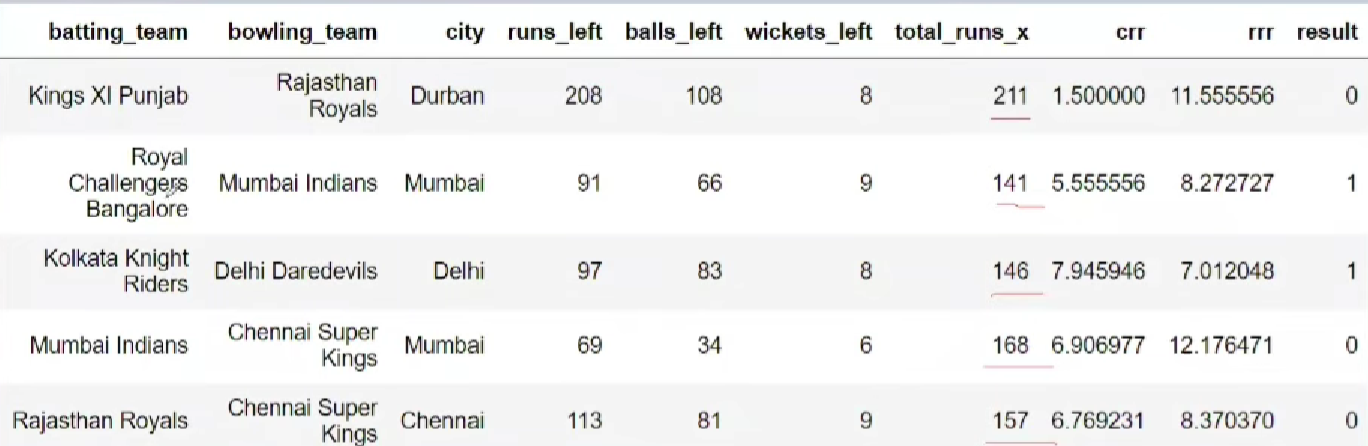
so we'll first make ammends by doing whatever we can to make our df like that!


In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
import pickle
print("All libraries successfully imported")

All libraries successfully imported


In [2]:
#importing data
match_df=pd.read_csv("matches.csv")
delivery=pd.read_csv("deliveries.csv")
print()

In [3]:
# we need the runs scored in each inning, so that we can find the ki target kitna banana h, so that we can predict k bhai kaise banega itna!
#but in our data we have the the runs scored ballwise, in this case, we'd need to do some Feature Engineering
total_score = delivery.groupby(['match_id','inning']).sum()['total_runs'].reset_index() #reset_index just makes it a pandas ka df
total_score #is a multi-index series, through which we are getting a total_runs score per inning, every match

,match_id,inning,total_runs
0,1,1,207
1,1,2,172
2,2,1,184
3,2,2,187
4,3,1,183
...,...,...,...
1523,11413,2,170
1524,11414,1,155
1525,11414,2,162
1526,11415,1,152


In [4]:
#but we only want the sum of runs for the first innings, as we are counting upon the TARGET, so cleaning that
total_score = total_score[total_score['inning'] == 1]
#total_score['total_runs']+=1 #incrementing all the values of total_runs by 1 as jitna first team banati h, second team ko us se 1 zyada banana hota h, target is 1 more than the sum run of team1
#print(total_score) #ye target hi print kr rha h, upar waali line comment kr di h, nhi to baar baar target 1 se bad jaa rha h :_)

#renaming the total_runs as target
total_score.rename(columns={'total_runs': 'target'}, inplace=True)
total_score

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\582178441.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_score.rename(columns={'total_runs': 'target'}, inplace=True)


,match_id,inning,target
0,1,1,207
2,2,1,184
4,3,1,183
6,4,1,163
8,5,1,157
...,...,...,...
1518,11347,1,143
1520,11412,1,136
1522,11413,1,171
1524,11414,1,155


In [5]:
#Now that we have got the total runs scored per match as targets
#We'ld have to merge it in the initial matches DF, on the column, match_id
match_df = match_df.merge(total_score[['match_id','target']],left_on='id',right_on='match_id')
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,target
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
1,2,IPL-2017,Pune,06-04-2017,Mumbai Indians,Rising Pune Supergiant,Rising Pune Supergiant,field,normal,0,Rising Pune Supergiant,0,7,SPD Smith,Maharashtra Cricket Association Stadium,A Nand Kishore,S Ravi,NaN,2,184
2,3,IPL-2017,Rajkot,07-04-2017,Gujarat Lions,Kolkata Knight Riders,Kolkata Knight Riders,field,normal,0,Kolkata Knight Riders,0,10,CA Lynn,Saurashtra Cricket Association Stadium,Nitin Menon,CK Nandan,NaN,3,183
3,4,IPL-2017,Indore,08-04-2017,Rising Pune Supergiant,Kings XI Punjab,Kings XI Punjab,field,normal,0,Kings XI Punjab,0,6,GJ Maxwell,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,4,163
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Daredevils,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [6]:
#DATA PRE-PROCESSING! in match_dfm
#thoda sa we'ld ahve to preprocess, as in the history of IPL there have been many teams that have played, who don't now! so we remove their names! :)

#looking for all the unique teams that play
# match_df["team1"].unique()

#finalised name of teams added in a list, to go in the df
teams = [
    'Sunrisers Hyderabad',
    'Mumbai Indians',
    'Royal Challengers Bangalore',
    'Kolkata Knight Riders',
    'Kings XI Punjab',
    'Chennai Super Kings',
    'Rajasthan Royals',
    'Delhi Capitals'
]

#replacing team name from Delhi Daredevils to Delhi Capitals
match_df['team1'] = match_df['team1'].str.replace('Delhi Daredevils','Delhi Capitals')
match_df['team2'] = match_df['team2'].str.replace('Delhi Daredevils','Delhi Capitals')

#Replacing team name from Deccan Chargers to Sunrisers Hyderabad
match_df['team1'] = match_df['team1'].str.replace('Deccan Chargers','Sunrisers Hyderabad')
match_df['team2'] = match_df['team2'].str.replace('Deccan Chargers','Sunrisers Hyderabad')

#team1 and team2 k columns me sirf unhi teams ka naam rakho jo teams list me hai!
match_df = match_df[match_df['team1'].isin(teams)]
match_df = match_df[match_df['team2'].isin(teams)]

#also we want our model only to predict the values for non_dl matches! so we remove those rows where dl_applied = 1
match_df=match_df[match_df['dl_applied']==0]
match_df

,id,Season,city,date,team1,team2,toss_winner,toss_decision,result,dl_applied,winner,win_by_runs,win_by_wickets,player_of_match,venue,umpire1,umpire2,umpire3,match_id,target
0,1,IPL-2017,Hyderabad,05-04-2017,Sunrisers Hyderabad,Royal Challengers Bangalore,Royal Challengers Bangalore,field,normal,0,Sunrisers Hyderabad,35,0,Yuvraj Singh,"Rajiv Gandhi International Stadium, Uppal",AY Dandekar,NJ Llong,NaN,1,207
4,5,IPL-2017,Bangalore,08-04-2017,Royal Challengers Bangalore,Delhi Capitals,Royal Challengers Bangalore,bat,normal,0,Royal Challengers Bangalore,15,0,KM Jadhav,M Chinnaswamy Stadium,NaN,NaN,NaN,5,157
6,7,IPL-2017,Mumbai,09-04-2017,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,N Rana,Wankhede Stadium,Nitin Menon,CK Nandan,NaN,7,178
7,8,IPL-2017,Indore,10-04-2017,Royal Challengers Bangalore,Kings XI Punjab,Royal Challengers Bangalore,bat,normal,0,Kings XI Punjab,0,8,AR Patel,Holkar Cricket Stadium,AK Chaudhary,C Shamshuddin,NaN,8,148
9,10,IPL-2017,Mumbai,12-04-2017,Sunrisers Hyderabad,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,4,JJ Bumrah,Wankhede Stadium,Nitin Menon,CK Nandan,NaN,10,158
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,11347,IPL-2019,Mumbai,05-05-2019,Kolkata Knight Riders,Mumbai Indians,Mumbai Indians,field,normal,0,Mumbai Indians,0,9,HH Pandya,Wankhede Stadium,Nanda Kishore,O Nandan,S Ravi,11347,143
752,11412,IPL-2019,Chennai,07-05-2019,Chennai Super Kings,Mumbai Indians,Chennai Super Kings,bat,normal,0,Mumbai Indians,0,6,AS Yadav,M. A. Chidambaram Stadium,Nigel Llong,Nitin Menon,Ian Gould,11412,136
753,11413,IPL-2019,Visakhapatnam,08-05-2019,Sunrisers Hyderabad,Delhi Capitals,Delhi Capitals,field,normal,0,Delhi Capitals,0,2,RR Pant,ACA-VDCA Stadium,NaN,NaN,NaN,11413,171
754,11414,IPL-2019,Visakhapatnam,10-05-2019,Delhi Capitals,Chennai Super Kings,Chennai Super Kings,field,normal,0,Chennai Super Kings,0,6,F du Plessis,ACA-VDCA Stadium,Sundaram Ravi,Bruce Oxenford,Chettithody Shamshuddin,11414,155


In [7]:
#we just need these 4 column names in our final and adament datset! :O
match_df = match_df[['match_id','city','winner','target']]
match_df


,match_id,city,winner,target
0,1,Hyderabad,Sunrisers Hyderabad,207
4,5,Bangalore,Royal Challengers Bangalore,157
6,7,Mumbai,Mumbai Indians,178
7,8,Indore,Kings XI Punjab,148
9,10,Mumbai,Mumbai Indians,158
...,...,...,...,...
751,11347,Mumbai,Mumbai Indians,143
752,11412,Chennai,Mumbai Indians,136
753,11413,Visakhapatnam,Delhi Capitals,171
754,11414,Visakhapatnam,Chennai Super Kings,155


In [8]:
#DATA PRE-PROCESSING in delivery_df
delivery_df = match_df.merge(delivery,on='match_id')
delivery_df

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,Hyderabad,Sunrisers Hyderabad,207,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,...,0,0,0,0,0,2,2,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,0,1,0,1,NaN,NaN,NaN
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,0,2,0,2,NaN,NaN,NaN
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,0,1,0,1,SR Watson,run out,KH Pandya
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,0,2,0,2,NaN,NaN,NaN


In [9]:
#sirf second innings ka data chahiye na! so why to worry for the first inning, hatao saale ko?!
delivery_df = delivery_df[delivery_df['inning'] == 2]
print(delivery_df)

        match_id       city               winner  target  inning  \
125            1  Hyderabad  Sunrisers Hyderabad     207       2   
126            1  Hyderabad  Sunrisers Hyderabad     207       2   
127            1  Hyderabad  Sunrisers Hyderabad     207       2   
128            1  Hyderabad  Sunrisers Hyderabad     207       2   
129            1  Hyderabad  Sunrisers Hyderabad     207       2   
...          ...        ...                  ...     ...     ...   
149573     11415  Hyderabad       Mumbai Indians     152       2   
149574     11415  Hyderabad       Mumbai Indians     152       2   
149575     11415  Hyderabad       Mumbai Indians     152       2   
149576     11415  Hyderabad       Mumbai Indians     152       2   
149577     11415  Hyderabad       Mumbai Indians     152       2   

                       batting_team         bowling_team  over  ball  \
125     Royal Challengers Bangalore  Sunrisers Hyderabad     1     1   
126     Royal Challengers Bangalore  Su

In [10]:
#finding current runs, ki 1 particular ball pr kitne runs banaye h kisi team ne!
curr_score = delivery_df.groupby('match_id')
curr_score = curr_score['total_runs'].cumsum()
curr_df={ 'current_score':curr_score}
curr_df=pd.DataFrame(curr_df)
delivery_df['current_score']=curr_df['current_score']

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\161906329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['current_score']=curr_df['current_score']


In [11]:
delivery_df

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,current_score
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,0,1,0,1,NaN,NaN,NaN,1
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,0,NaN,NaN,NaN,1
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,0,NaN,NaN,NaN,1
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,0,2,0,2,NaN,NaN,NaN,3
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,0,4,0,4,NaN,NaN,NaN,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,0,1,0,1,NaN,NaN,NaN,152
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,0,2,0,2,NaN,NaN,NaN,154
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,0,1,0,1,SR Watson,run out,KH Pandya,155
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,0,2,0,2,NaN,NaN,NaN,157


In [12]:
#ab hume nikalna h runs left -> target - current_score
delivery_df['runs_left'] = delivery_df['target'] - delivery_df['current_score']

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\2939171789.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['runs_left'] = delivery_df['target'] - delivery_df['current_score']


In [13]:
delivery_df

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,current_score,runs_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,0,1,0,1,NaN,NaN,NaN,1,206
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,NaN,1,206
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,0,NaN,NaN,NaN,1,206
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,0,2,0,2,NaN,NaN,NaN,3,204
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,0,4,0,4,NaN,NaN,NaN,7,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,0,1,0,1,NaN,NaN,NaN,152,0
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,0,2,0,2,NaN,NaN,NaN,154,-2
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,0,1,0,1,SR Watson,run out,KH Pandya,155,-3
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,0,2,0,2,NaN,NaN,NaN,157,-5


In [14]:
delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\517047302.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['balls_left'] = 126 - (delivery_df['over']*6 + delivery_df['ball'])


In [15]:
delivery_df

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,1,0,1,NaN,NaN,NaN,1,206,119
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,118
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,NaN,1,206,117
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,0,2,0,2,NaN,NaN,NaN,3,204,116
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,0,4,0,4,NaN,NaN,NaN,7,200,115
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,0,1,0,1,NaN,NaN,NaN,152,0,4
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,0,2,0,2,NaN,NaN,NaN,154,-2,3
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,0,1,0,1,SR Watson,run out,KH Pandya,155,-3,2
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,0,2,0,2,NaN,NaN,NaN,157,-5,1


In [16]:
#Wickets left nikalna padega!
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0") #player_dismessed ki nan values ko 0 kar do
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1") #player_dismissed ki non nan values ko 1 kar do
delivery_df['player_dismissed'] = delivery_df['player_dismissed'].astype('int') #poore column ka type integer kr do

#updated delivery_df

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\311695487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['player_dismissed'] = delivery_df['player_dismissed'].fillna("0") #player_dismessed ki nan values ko 0 kar do
C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\311695487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['player_dismissed'] = delivery_df['player_dismissed'].apply(lambda x:x if x == "0" else "1") #player_dismissed ki non nan values ko 1 kar 

In [17]:
#1 column banana h cumsum karke, and usko append karna h delivery_df me
wickets = delivery_df.groupby('match_id')
wickets = wickets['player_dismissed'].cumsum()
delivery_df['wickets']=10-wickets

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\3701053452.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['wickets']=10-wickets


In [18]:
delivery_df.head(40)

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,1,0,NaN,NaN,1,206,119,10
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,118,10
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,0,0,NaN,NaN,1,206,117,10
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,2,0,NaN,NaN,3,204,116,10
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,4,0,NaN,NaN,7,200,115,10
130,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,6,Mandeep Singh,...,4,0,4,0,NaN,NaN,11,196,114,10
131,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,2,1,CH Gayle,...,0,0,0,0,NaN,NaN,11,196,113,10
132,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,2,2,CH Gayle,...,0,0,0,0,NaN,NaN,11,196,112,10
133,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,2,3,CH Gayle,...,1,0,1,0,NaN,NaN,12,195,111,10
134,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,2,4,Mandeep Singh,...,0,0,0,0,NaN,NaN,12,195,110,10


In [19]:
#Calculating the crr => current_score/overs_happened
delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])

#Calculating the rrr => runs_left/overs_left
delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\3412872733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['crr'] = (delivery_df['current_score']*6)/(120 - delivery_df['balls_left'])
C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\3412872733.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['rrr'] = (delivery_df['runs_left']*6)/delivery_df['balls_left']


In [20]:
delivery_df

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,total_runs,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets,crr,rrr
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,1,0,NaN,NaN,1,206,119,10,6.000000,10.386555
126,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,2,Mandeep Singh,...,0,0,NaN,NaN,1,206,118,10,3.000000,10.474576
127,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,3,Mandeep Singh,...,0,0,NaN,NaN,1,206,117,10,2.000000,10.564103
128,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,4,Mandeep Singh,...,2,0,NaN,NaN,3,204,116,10,4.500000,10.551724
129,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,5,Mandeep Singh,...,4,0,NaN,NaN,7,200,115,10,8.400000,10.434783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149573,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,2,RA Jadeja,...,1,0,NaN,NaN,152,0,4,5,7.862069,0.000000
149574,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,3,SR Watson,...,2,0,NaN,NaN,154,-2,3,5,7.897436,-4.000000
149575,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,4,SR Watson,...,1,1,run out,KH Pandya,155,-3,2,4,7.881356,-9.000000
149576,11415,Hyderabad,Mumbai Indians,152,2,Chennai Super Kings,Mumbai Indians,20,5,SN Thakur,...,2,0,NaN,NaN,157,-5,1,4,7.915966,-30.000000


In [21]:
#lastt column we have to work up is to bring the result in a binary, 0 or 1
#intution is if the winner == batting_team, then the result is 1 else 0. Remember we are only talking about the second innings, and are calculating the win probability at any given instance of time, after the target is set!
def result(row):
    return 1 if row['batting_team'] == row['winner'] else 0

In [22]:
delivery_df['result'] = delivery_df.apply(result,axis=1)

C:\Users\PRITPAL SINGH\AppData\Local\Temp\ipykernel_24124\955537649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivery_df['result'] = delivery_df.apply(result,axis=1)


In [23]:
delivery_df.head(1)

,match_id,city,winner,target,inning,batting_team,bowling_team,over,ball,batsman,...,player_dismissed,dismissal_kind,fielder,current_score,runs_left,balls_left,wickets,crr,rrr,result
125,1,Hyderabad,Sunrisers Hyderabad,207,2,Royal Challengers Bangalore,Sunrisers Hyderabad,1,1,CH Gayle,...,0,NaN,NaN,1,206,119,10,6.0,10.386555,0


In [24]:
#go to the first cell, and see that we were only looking for a select few columns on which our model will work, hooray we have got all of em!!!
final_df = delivery_df[['batting_team','bowling_team','city','runs_left','balls_left','wickets','target','crr','rrr','result']]
final_df

,batting_team,bowling_team,city,runs_left,balls_left,wickets,target,crr,rrr,result
125,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206,119,10,207,6.000000,10.386555,0
126,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206,118,10,207,3.000000,10.474576,0
127,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,206,117,10,207,2.000000,10.564103,0
128,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,204,116,10,207,4.500000,10.551724,0
129,Royal Challengers Bangalore,Sunrisers Hyderabad,Hyderabad,200,115,10,207,8.400000,10.434783,0
...,...,...,...,...,...,...,...,...,...,...
149573,Chennai Super Kings,Mumbai Indians,Hyderabad,0,4,5,152,7.862069,0.000000,0
149574,Chennai Super Kings,Mumbai Indians,Hyderabad,-2,3,5,152,7.897436,-4.000000,0
149575,Chennai Super Kings,Mumbai Indians,Hyderabad,-3,2,4,152,7.881356,-9.000000,0
149576,Chennai Super Kings,Mumbai Indians,Hyderabad,-5,1,4,152,7.915966,-30.000000,0


In [25]:
#shuffle the data, else, the model so trained will be baised!
final_df = final_df.sample(final_df.shape[0])
final_df

,batting_team,bowling_team,city,runs_left,balls_left,wickets,target,crr,rrr,result
30601,Deccan Chargers,Kolkata Knight Riders,Johannesburg,57,32,8,160,7.022727,10.687500,1
67124,Royal Challengers Bangalore,Deccan Chargers,Bangalore,135,82,10,181,7.263158,9.878049,1
10717,Mumbai Indians,Kolkata Knight Riders,Kolkata,121,107,10,137,7.384615,6.785047,1
13329,Mumbai Indians,Rajasthan Royals,Mumbai,90,100,10,103,3.900000,5.400000,1
83255,Kolkata Knight Riders,Royal Challengers Bangalore,Ranchi,90,92,9,115,5.357143,5.869565,1
...,...,...,...,...,...,...,...,...,...,...
139131,Sunrisers Hyderabad,Delhi Capitals,Delhi,31,46,8,134,8.351351,4.043478,1
18292,Delhi Daredevils,Mumbai Indians,Delhi,9,10,5,176,9.109091,5.400000,1
111136,Mumbai Indians,Royal Challengers Bangalore,Mumbai,102,35,8,235,9.388235,17.485714,0
6574,Kolkata Knight Riders,Mumbai Indians,Kolkata,19,11,3,173,8.477064,10.363636,0


## test_train_split

In [26]:
final_df.dropna(inplace=True)
final_df = final_df[final_df['balls_left'] != 0]

In [27]:
X = final_df.iloc[:,:-1]
y = final_df.iloc[:,-1]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)

In [28]:
X_train

,batting_team,bowling_team,city,runs_left,balls_left,wickets,target,crr,rrr
138323,Delhi Capitals,Kings XI Punjab,Mohali,159,110,9,175,9.600000,8.672727
131673,Royal Challengers Bangalore,Delhi Daredevils,Delhi,22,16,6,188,9.576923,8.250000
63736,Kolkata Knight Riders,Deccan Chargers,Cuttack,54,56,6,126,6.750000,5.785714
113966,Chennai Super Kings,Mumbai Indians,Kolkata,197,111,10,202,3.333333,10.648649
39115,Chennai Super Kings,Rajasthan Royals,Ahmedabad,75,40,7,177,7.650000,11.250000
...,...,...,...,...,...,...,...,...,...
128002,Kolkata Knight Riders,Royal Challengers Bangalore,Bengaluru,60,36,8,185,8.928571,10.000000
132717,Kings XI Punjab,Mumbai Indians,Mumbai,118,68,9,197,9.115385,10.411765
127988,Kolkata Knight Riders,Royal Challengers Bangalore,Bengaluru,81,49,9,185,8.788732,9.918367
71714,Mumbai Indians,Chennai Super Kings,Bangalore,127,78,8,187,8.571429,9.769231


### Encoding (one-hot) 

In [29]:
#since our first three columns are strings, and a model can't work with that shit, so
#we'ld have to fuckin ONE-HOT encode them to nums
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

trf = ColumnTransformer([
    ('trf',OneHotEncoder(sparse=False,drop='first'),['batting_team','bowling_team','city'])
]
,remainder='passthrough')

### Model Selection & Training


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

### Pipeline banayenge
What is an ML pipeline? One definition of an ML pipeline is a means of automating the machine learning workflow by enabling data to be transformed and correlated into a model that can then be analyzed to achieve outputs. This type of ML pipeline makes the process of inputting data into the ML model fully automated.

In [31]:
pipe = Pipeline(steps=[
    ('step1',trf),
    ('step2',LogisticRegression(solver='liblinear'))#but if we want to show probabilities of winning, ie, who's likely to win, its better to use, Logistic Regression
    #('step2',RandomForestClassifier())#if we create an object of RandomForest, then the game is over, finish... tata tada.. 99.8% accurate model train ho rha h...
])  #in case we want to be absuletly sure of whose gonna win, we opt for Random forest in such cases

In [32]:
pipe.fit(X_train,y_train)

c:\Users\PRITPAL SINGH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('step1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('trf',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['batting_team',
                                                   'bowling_team', 'city'])])),
                ('step2', LogisticRegression(solver='liblinear'))])

In [33]:
y_pred = pipe.predict(X_test)

In [34]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7978134417268203

In [35]:
pipe.predict_proba(X_test)[10]

array([0.62035657, 0.37964343])

### Other models

In [43]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier # Import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
# Define the pipeline with DecisionTreeClassifier
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', DecisionTreeClassifier()) # Use DecisionTreeClassifier instead of LogisticRegression
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


c:\Users\PRITPAL SINGH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.990819258532483

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

# Assume trf is the transformer object for data preprocessing
# Replace LogisticRegression with KNeighborsClassifier
pipe = Pipeline(steps=[
    ('step1', trf),
    ('step2', KNeighborsClassifier())  # Using KNeighborsClassifier for KNN
])

pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)


c:\Users\PRITPAL SINGH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


0.8934753661784287

c:\Users\PRITPAL SINGH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\PRITPAL SINGH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\PRITPAL SINGH\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


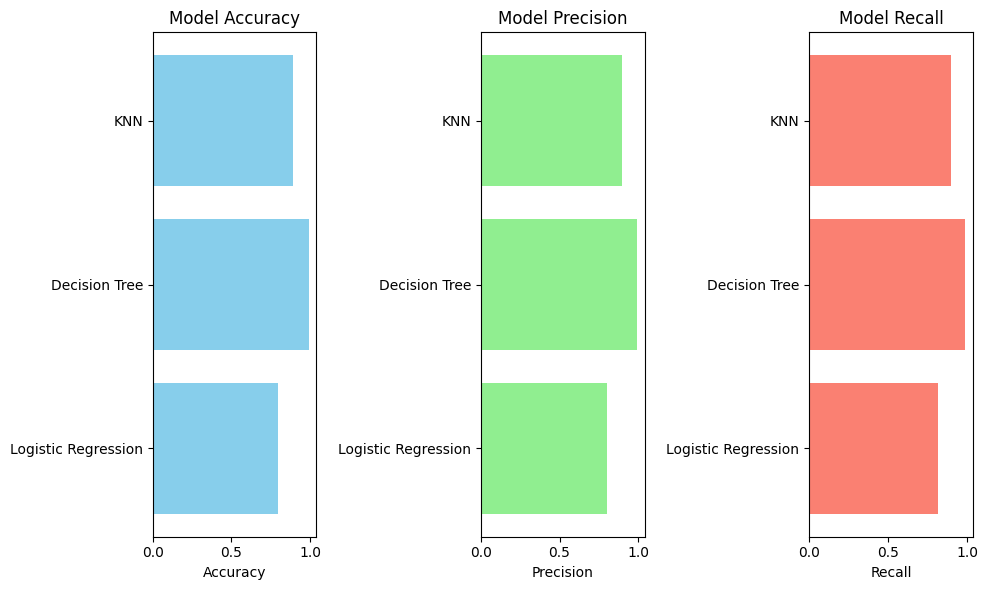

In [45]:
#plotting the metrics of different models
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt

# Assuming X_train, X_test, y_train, y_test are already defined

# Importing necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Initialize models
models = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'Decision Tree': DecisionTreeClassifier(),
    'KNN': KNeighborsClassifier()
}

# Initializing dictionaries to store evaluation metrics
accuracy_scores = {}
precision_scores = {}
recall_scores = {}

# Loop through each model
for name, model in models.items():
    # Create pipeline with data preprocessing and current model
    pipe = Pipeline(steps=[
        ('step1', trf),  # Assuming trf is the transformer object for data preprocessing
        ('step2', model)
    ])
    
    # Fit the model
    pipe.fit(X_train, y_train)
    
    # Predict labels
    y_pred = pipe.predict(X_test)
    
    # Calculate evaluation metrics
    accuracy_scores[name] = accuracy_score(y_test, y_pred)
    precision_scores[name] = precision_score(y_test, y_pred)
    recall_scores[name] = recall_score(y_test, y_pred)

# Plotting
plt.figure(figsize=(10, 6))

# Accuracy
plt.subplot(1, 3, 1)
plt.barh(list(accuracy_scores.keys()), list(accuracy_scores.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Model Accuracy')

# Precision
plt.subplot(1, 3, 2)
plt.barh(list(precision_scores.keys()), list(precision_scores.values()), color='lightgreen')
plt.xlabel('Precision')
plt.title('Model Precision')

# Recall
plt.subplot(1, 3, 3)
plt.barh(list(recall_scores.keys()), list(recall_scores.values()), color='salmon')
plt.xlabel('Recall')
plt.title('Model Recall')

plt.tight_layout()
plt.show()


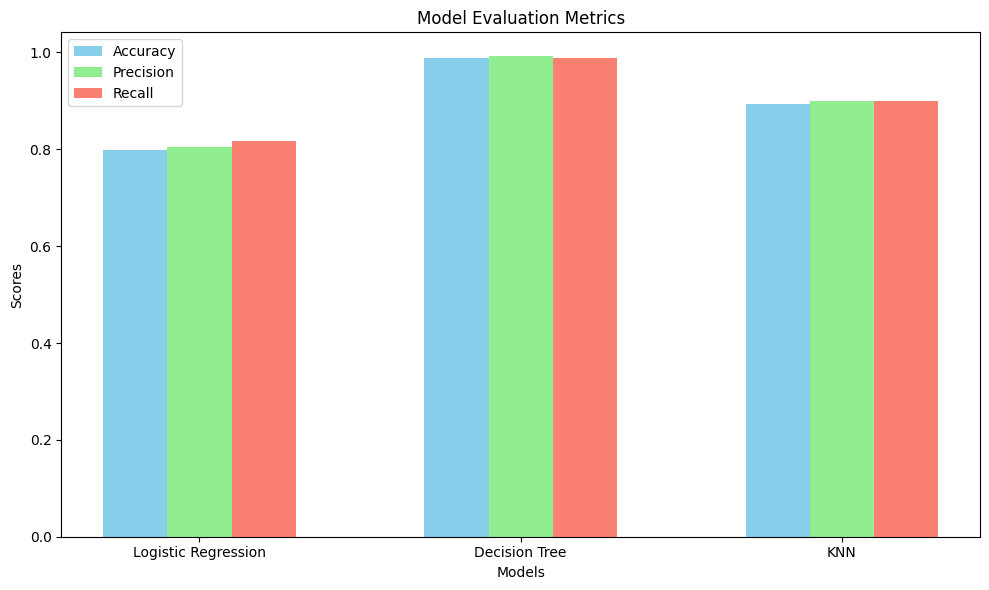

In [47]:
import numpy as np

# Plotting
plt.figure(figsize=(10, 6))

models_list = list(models.keys())
num_models = len(models_list)
bar_width = 0.2
index = np.arange(num_models)

# Accuracy
plt.bar(index, list(accuracy_scores.values()), bar_width, label='Accuracy', color='skyblue')
# Precision
plt.bar(index + bar_width, list(precision_scores.values()), bar_width, label='Precision', color='lightgreen')
# Recall
plt.bar(index + 2 * bar_width, list(recall_scores.values()), bar_width, label='Recall', color='salmon')

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Evaluation Metrics')
plt.xticks(index + bar_width, models_list)
plt.legend()

plt.tight_layout()
plt.show()


### Match Summary

In [36]:
def match_summary(row):
    print("Batting Team-" + row['batting_team'] + " | Bowling Team-" + row['bowling_team'] + " | Target- " + str(row['total_runs_x']))

In [46]:
def match_progression(x_df,match_id,pipe):
    match = x_df[x_df['match_id'] == match_id]
    match = match[(match['ball'] == 6)]
    temp_df = match[['batting_team','bowling_team','city','runs_left','balls_left','wickets','target','crr','rrr']].dropna()
    temp_df = temp_df[temp_df['balls_left'] != 0]
    result = pipe.predict_proba(temp_df)
    temp_df['lose'] = np.round(result.T[0]*100,1)
    temp_df['win'] = np.round(result.T[1]*100,1)
    temp_df['end_of_over'] = range(1,temp_df.shape[0]+1)
    
    target = temp_df['target'].values[0]
    runs = list(temp_df['runs_left'].values)
    new_runs = runs[:]
    runs.insert(0,target)
    temp_df['runs_after_over'] = np.array(runs)[:-1] - np.array(new_runs)
    wickets = list(temp_df['wickets'].values)
    new_wickets = wickets[:]
    new_wickets.insert(0,10)
    wickets.append(0)
    w = np.array(wickets)
    nw = np.array(new_wickets)
    temp_df['wickets_in_over'] = (nw - w)[0:temp_df.shape[0]]
    
    print("Target-",target)
    temp_df = temp_df[['end_of_over','runs_after_over','wickets_in_over','lose','win']]
    return temp_df,target

#if you give this functiton the entire detail of the match, match_id and if u give it your model, then this function will give you the win probability
#of the chasing team after the end of every over!


In [38]:
temp_df,target = match_progression(delivery_df,74,pipe)
temp_df

Target- 178


,end_of_over,runs_after_over,wickets_in_over,lose,win
10459,1,4,0,56.3,43.7
10467,2,8,0,50.9,49.1
10473,3,1,0,57.8,42.2
10479,4,7,1,69.4,30.6
10485,5,12,0,59.2,40.8
10491,6,13,0,46.8,53.2
10497,7,9,0,40.9,59.1
10505,8,15,0,27.0,73.0
10511,9,7,0,24.9,75.1
10518,10,17,0,13.5,86.5


Text(0.5, 1.0, 'Target-178')

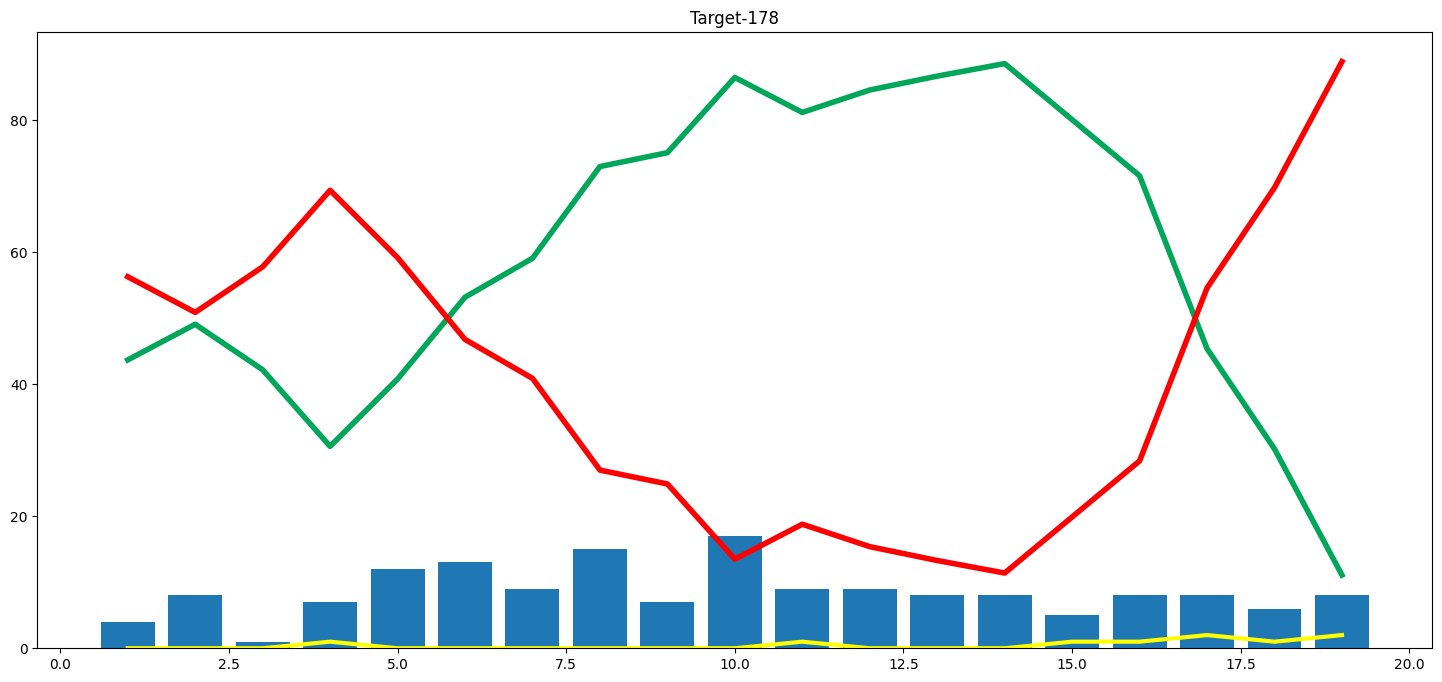

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,8))
plt.plot(temp_df['end_of_over'],temp_df['wickets_in_over'],color='yellow',linewidth=3)
plt.plot(temp_df['end_of_over'],temp_df['win'],color='#00a65a',linewidth=4)
plt.plot(temp_df['end_of_over'],temp_df['lose'],color='red',linewidth=4)
plt.bar(temp_df['end_of_over'],temp_df['runs_after_over'])
plt.title('Target-' + str(target))

In [40]:
teams

['Sunrisers Hyderabad',
 'Mumbai Indians',
 'Royal Challengers Bangalore',
 'Kolkata Knight Riders',
 'Kings XI Punjab',
 'Chennai Super Kings',
 'Rajasthan Royals',
 'Delhi Capitals']

In [41]:
delivery_df['city'].unique()

array(['Hyderabad', 'Bangalore', 'Mumbai', 'Indore', 'Kolkata', 'Delhi',
       'Chandigarh', 'Jaipur', 'Chennai', 'Cape Town', 'Port Elizabeth',
       'Durban', 'Centurion', 'East London', 'Johannesburg', 'Kimberley',
       'Bloemfontein', 'Ahmedabad', 'Cuttack', 'Nagpur', 'Dharamsala',
       'Visakhapatnam', 'Pune', 'Raipur', 'Ranchi', 'Abu Dhabi',
       'Sharjah', nan, 'Mohali', 'Bengaluru'], dtype=object)

In [42]:
import pickle
pickle.dump(pipe,open('pipe.pkl','wb'))